In [3]:
import numpy as np
# import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
import pickle

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
trained_randomRF_filename = 'trained_randomRF_model.sav'

### Data Preparation

In [6]:
def load_data():
    # Fetch the data
    data_raw = pd.read_csv('./bank-additional/bank-additional-full.csv',header=0,sep=';',na_values='unknown')
    data_raw['y'].replace('no', 0, inplace=True)
    data_raw['y'].replace('yes', 1, inplace=True)
    return data_raw

In [7]:
def preprocessing(data):
    clean_data = data.copy().drop('duration',axis=1)
    # Fill na
    clean_data.job.fillna('unknown',inplace = True)
    clean_data.marital.fillna('unknown',inplace = True)
    clean_data.education.fillna('unknown',inplace = True)
    clean_data.default.fillna('no',inplace = True)
    clean_data.housing.fillna('no',inplace = True)
    clean_data.loan.fillna('no',inplace = True)
    
    # Seperate between categorical and numerical data
    clean_data_obj = clean_data.select_dtypes(include=['object'])
    clean_data_num = clean_data.select_dtypes(exclude=['object'])
    
    # One-hot categorical data
    clean_data_obj = pd.get_dummies(clean_data_obj,drop_first=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(clean_data_num)
    clean_data_num = pd.DataFrame(scaler.transform(clean_data_num),columns=clean_data_num.keys())
    # Join back the data
    clean_data = clean_data_num.join(clean_data_obj)
    
    return clean_data

In [8]:
data_raw = load_data()

In [9]:
prep_data = preprocessing(data_raw)

In [10]:
# Split train/test set
from sklearn.model_selection import train_test_split
features = prep_data.dropna().drop('y',axis=1)
label = prep_data.dropna().y
train_x,test_x,train_y,test_y = train_test_split(features,label, test_size=0.33, random_state=42)

### Model Selections by Cross Validation


In [11]:
# Logistic Regression
lr_clf = LogisticRegression()
scores = cross_val_score(lr_clf,train_x,train_y,cv=3,scoring='roc_auc')

print(f"Logistic Regression model's average AUC: {scores.mean():.4f}")

Logistic Regression model's average AUC: 0.7939


In [12]:
# Decision Tree
tree_clf = DecisionTreeClassifier()
scores = cross_val_score(tree_clf,train_x,train_y,cv=10,scoring='roc_auc')

print(f"Tree Classifer model's average AUC: {scores.mean():.4f}")

Tree Classifer model's average AUC: 0.6260


In [13]:
# Random Forest
rf_clf = RandomForestClassifier()
scores = cross_val_score(rf_clf,train_x,train_y,cv=10,scoring='roc_auc')

print(f"Random Forest Classfier model's average AUC: {scores.mean():.4f}")

Random Forest Classfier model's average AUC: 0.7443


### Common

In [14]:
def eval_matrics(pred_class_y,pred_prob_y,label_y,model_name='Model'):
    # Matrics
    auc = roc_auc_score(label_y,pred_prob_y[:,1])
    print(f'{model_name} AUC is {auc:.4f}')
    acc = accuracy_score(label_y,pred_class_y)
    print(f'{model_name} Accuracy is {acc:.4f}')
    precision = precision_score(label_y,pred_class_y)
    print(f'{model_name} precision is {precision:.4f}')
    recall = recall_score(label_y,pred_class_y)
    print(f'{model_name} recall is {recall:.4f}')
    f1 = f1_score(label_y,pred_class_y)
    print(f'{model_name} f1-score is {f1:.4f}')
    # Confusion Matrix
    print(f'Confusion Matrix of {model_name}:')
    print(confusion_matrix(label_y,pred_class_y))
    return    

### Baseline

#### Logistic Regression Baseline

In [26]:
## Logistic Regression Baseline¶
# Fit and Predict
lr_clf = LogisticRegression().fit(train_x,train_y)
pred_class_y = lr_clf.predict(test_x)
pred_prob_y = lr_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'Logistic Regression Model')

Logistic Regression Model AUC is 0.7874
Logistic Regression Model Accuracy is 0.9004
Logistic Regression Model precision is 0.6856
Logistic Regression Model recall is 0.2199
Logistic Regression Model f1-score is 0.3330
Confusion Matrix of Logistic Regression Model:
[[11901   155]
 [ 1199   338]]


In [27]:
fpr_lr_base, tpr_lr_base ,_= roc_curve(test_y, pred_prob_y[:,1])

### Grid search

In [18]:
# Create Grid parameters
# linear regularization type (penalty)
penalty_type = ['l1','l2']

# Inverse of regularization strength (C)
reg_str = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 

# Weights associated with classes (class_weight)
cl_weight = [None, 'balanced']
# cl_weight = [None, 'balanced',{0:1,1:2}]

# Create the grid search parameters
lr_param_grid = {'penalty':penalty_type,
                  'C':reg_str,
                  'class_weight':cl_weight}
# Create a based model
lr_clf = LogisticRegression()
# Instantiate the grid search model
lr_grid_search = GridSearchCV(estimator = lr_clf, param_grid = lr_param_grid, cv=3, scoring ='roc_auc',verbose=1)
# Fit the grid search to the data
lr_grid_search.fit(train_x,train_y)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

### Evaluate Tuning Models

#### Tuned Logistic Regression Model 

In [20]:
lr_grid_search.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}

In [28]:
# Fit and Predict
lr_clf = LogisticRegression(penalty='l1', C=1, class_weight='balanced').fit(train_x,train_y)
pred_class_y = lr_clf.predict(test_x)
pred_prob_y = lr_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'Tuned LR Model')

Tuned LR Model AUC is 0.7878
Tuned LR Model Accuracy is 0.8281
Tuned LR Model precision is 0.3522
Tuned LR Model recall is 0.6200
Tuned LR Model f1-score is 0.4492
Confusion Matrix of Tuned LR Model:
[[10303  1753]
 [  584   953]]


In [30]:
fpr_lr_tuned, tpr_lr_tuned ,_= roc_curve(test_y, pred_prob_y[:,1])

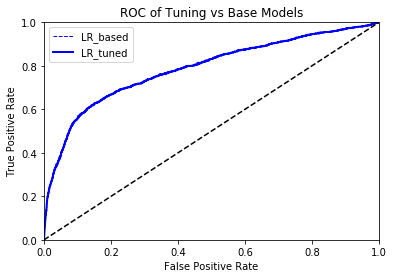

In [31]:
plt.plot(fpr_lr_base, tpr_lr_base, 'b--',linewidth=1, label='LR_based')
plt.plot(fpr_lr_tuned, tpr_lr_tuned, 'b-',linewidth=2, label='LR_tuned')
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Tuning vs Base Models')
plt.show()